In [2]:
import datetime as dt
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from pylab import *
from pandas.plotting import register_matplotlib_converters

register_matplotlib_converters()


data_src_path = 'data_source/AirPassengers.csv'
df = pd.read_csv(data_src_path)
df

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121
...,...,...
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390


In [3]:
df['dt'] =  pd.to_datetime(df['Month'], format='%Y-%m')
df

,Month,#Passengers,dt
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01
...,...,...,...
139,1960-08,606,1960-08-01
140,1960-09,508,1960-09-01
141,1960-10,461,1960-10-01
142,1960-11,390,1960-11-01


Text(0, 0.5, 'passengers')

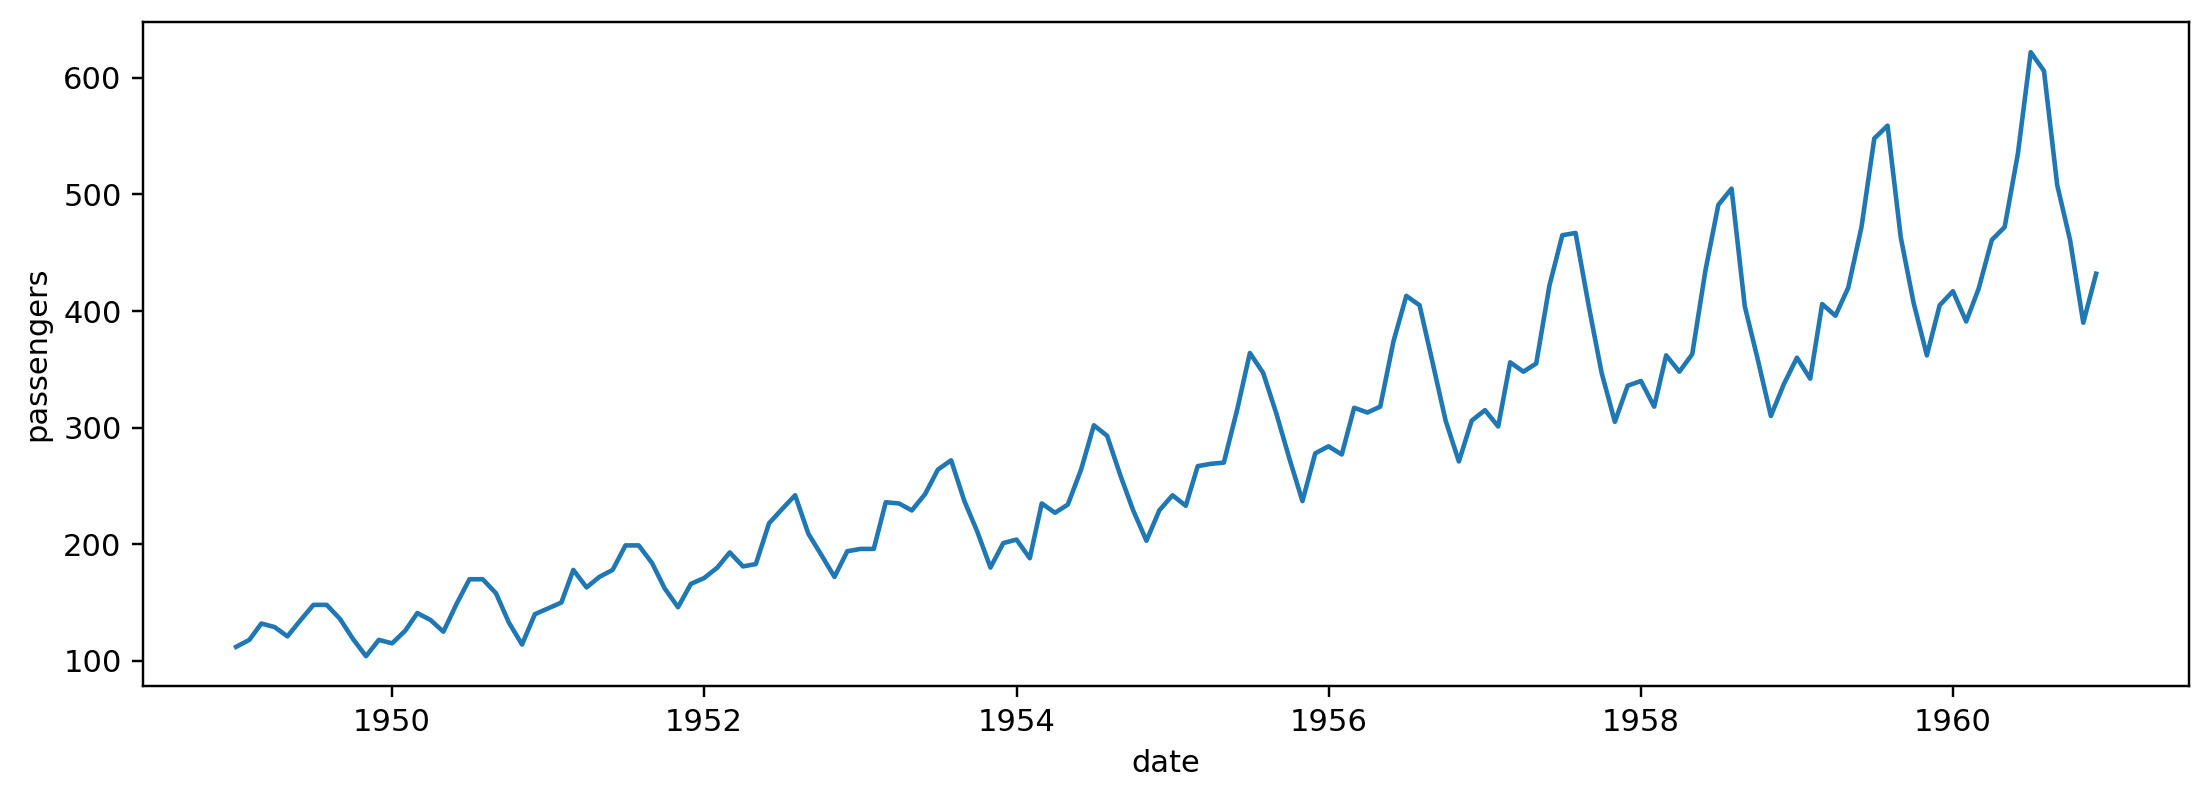

In [4]:
fig, axes = plt.subplots(figsize=(12,4), dpi=220)
axes.plot(df['dt'], df["#Passengers"])
axes.set_xlabel('date')
axes.set_ylabel('passengers')

In [5]:
points_to_drop = 12
season_len = 12
train_df = df[df['dt'] < df['dt'].iloc[-1] - dt.timedelta(days=points_to_drop*30)]
train_df

,Month,#Passengers,dt
0,1949-01,112,1949-01-01
1,1949-02,118,1949-02-01
2,1949-03,132,1949-03-01
3,1949-04,129,1949-04-01
4,1949-05,121,1949-05-01
...,...,...,...
127,1959-08,559,1959-08-01
128,1959-09,463,1959-09-01
129,1959-10,407,1959-10-01
130,1959-11,362,1959-11-01


Критерий Дики-Фуллера: p=0.992932


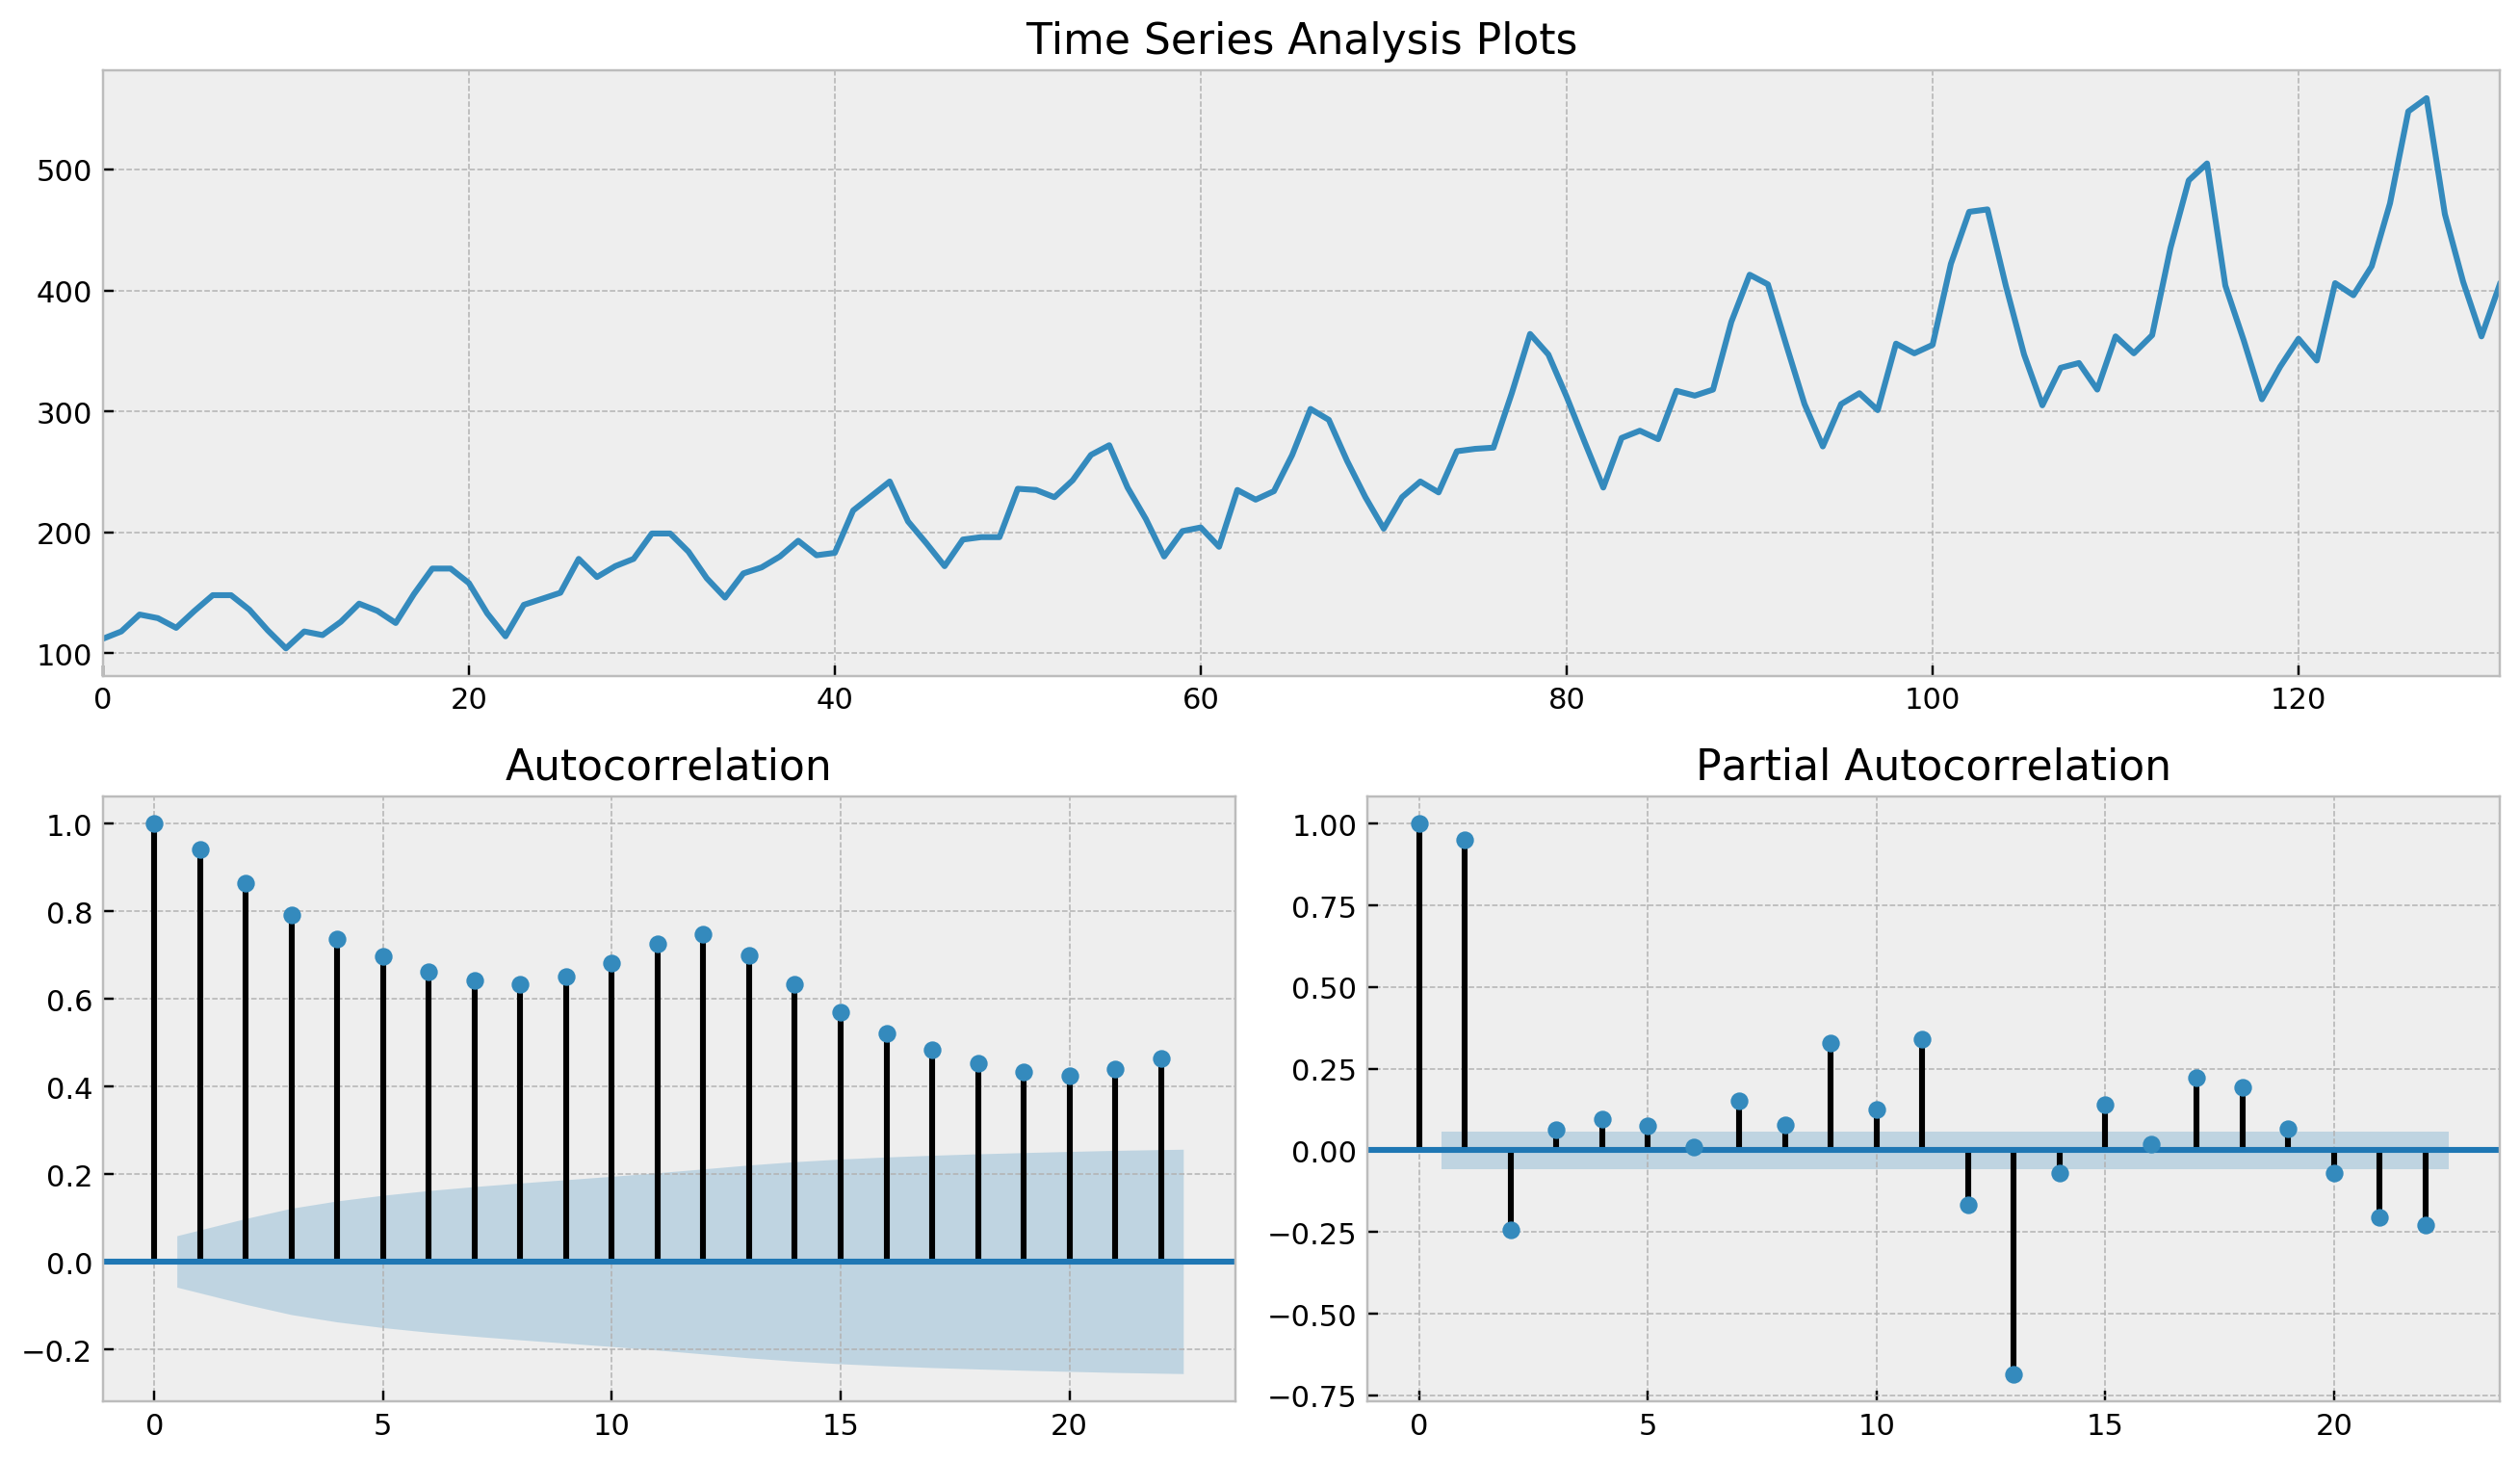

In [6]:
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
from scipy.optimize import minimize

def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize, dpi=220)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))

        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)

        print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(y)[1])

        plt.tight_layout()
    return 

tsplot(train_df["#Passengers"])

Критерий Дики-Фуллера: p=0.753706
Оптимальный параметр преобразования Бокса-Кокса: 0.128871


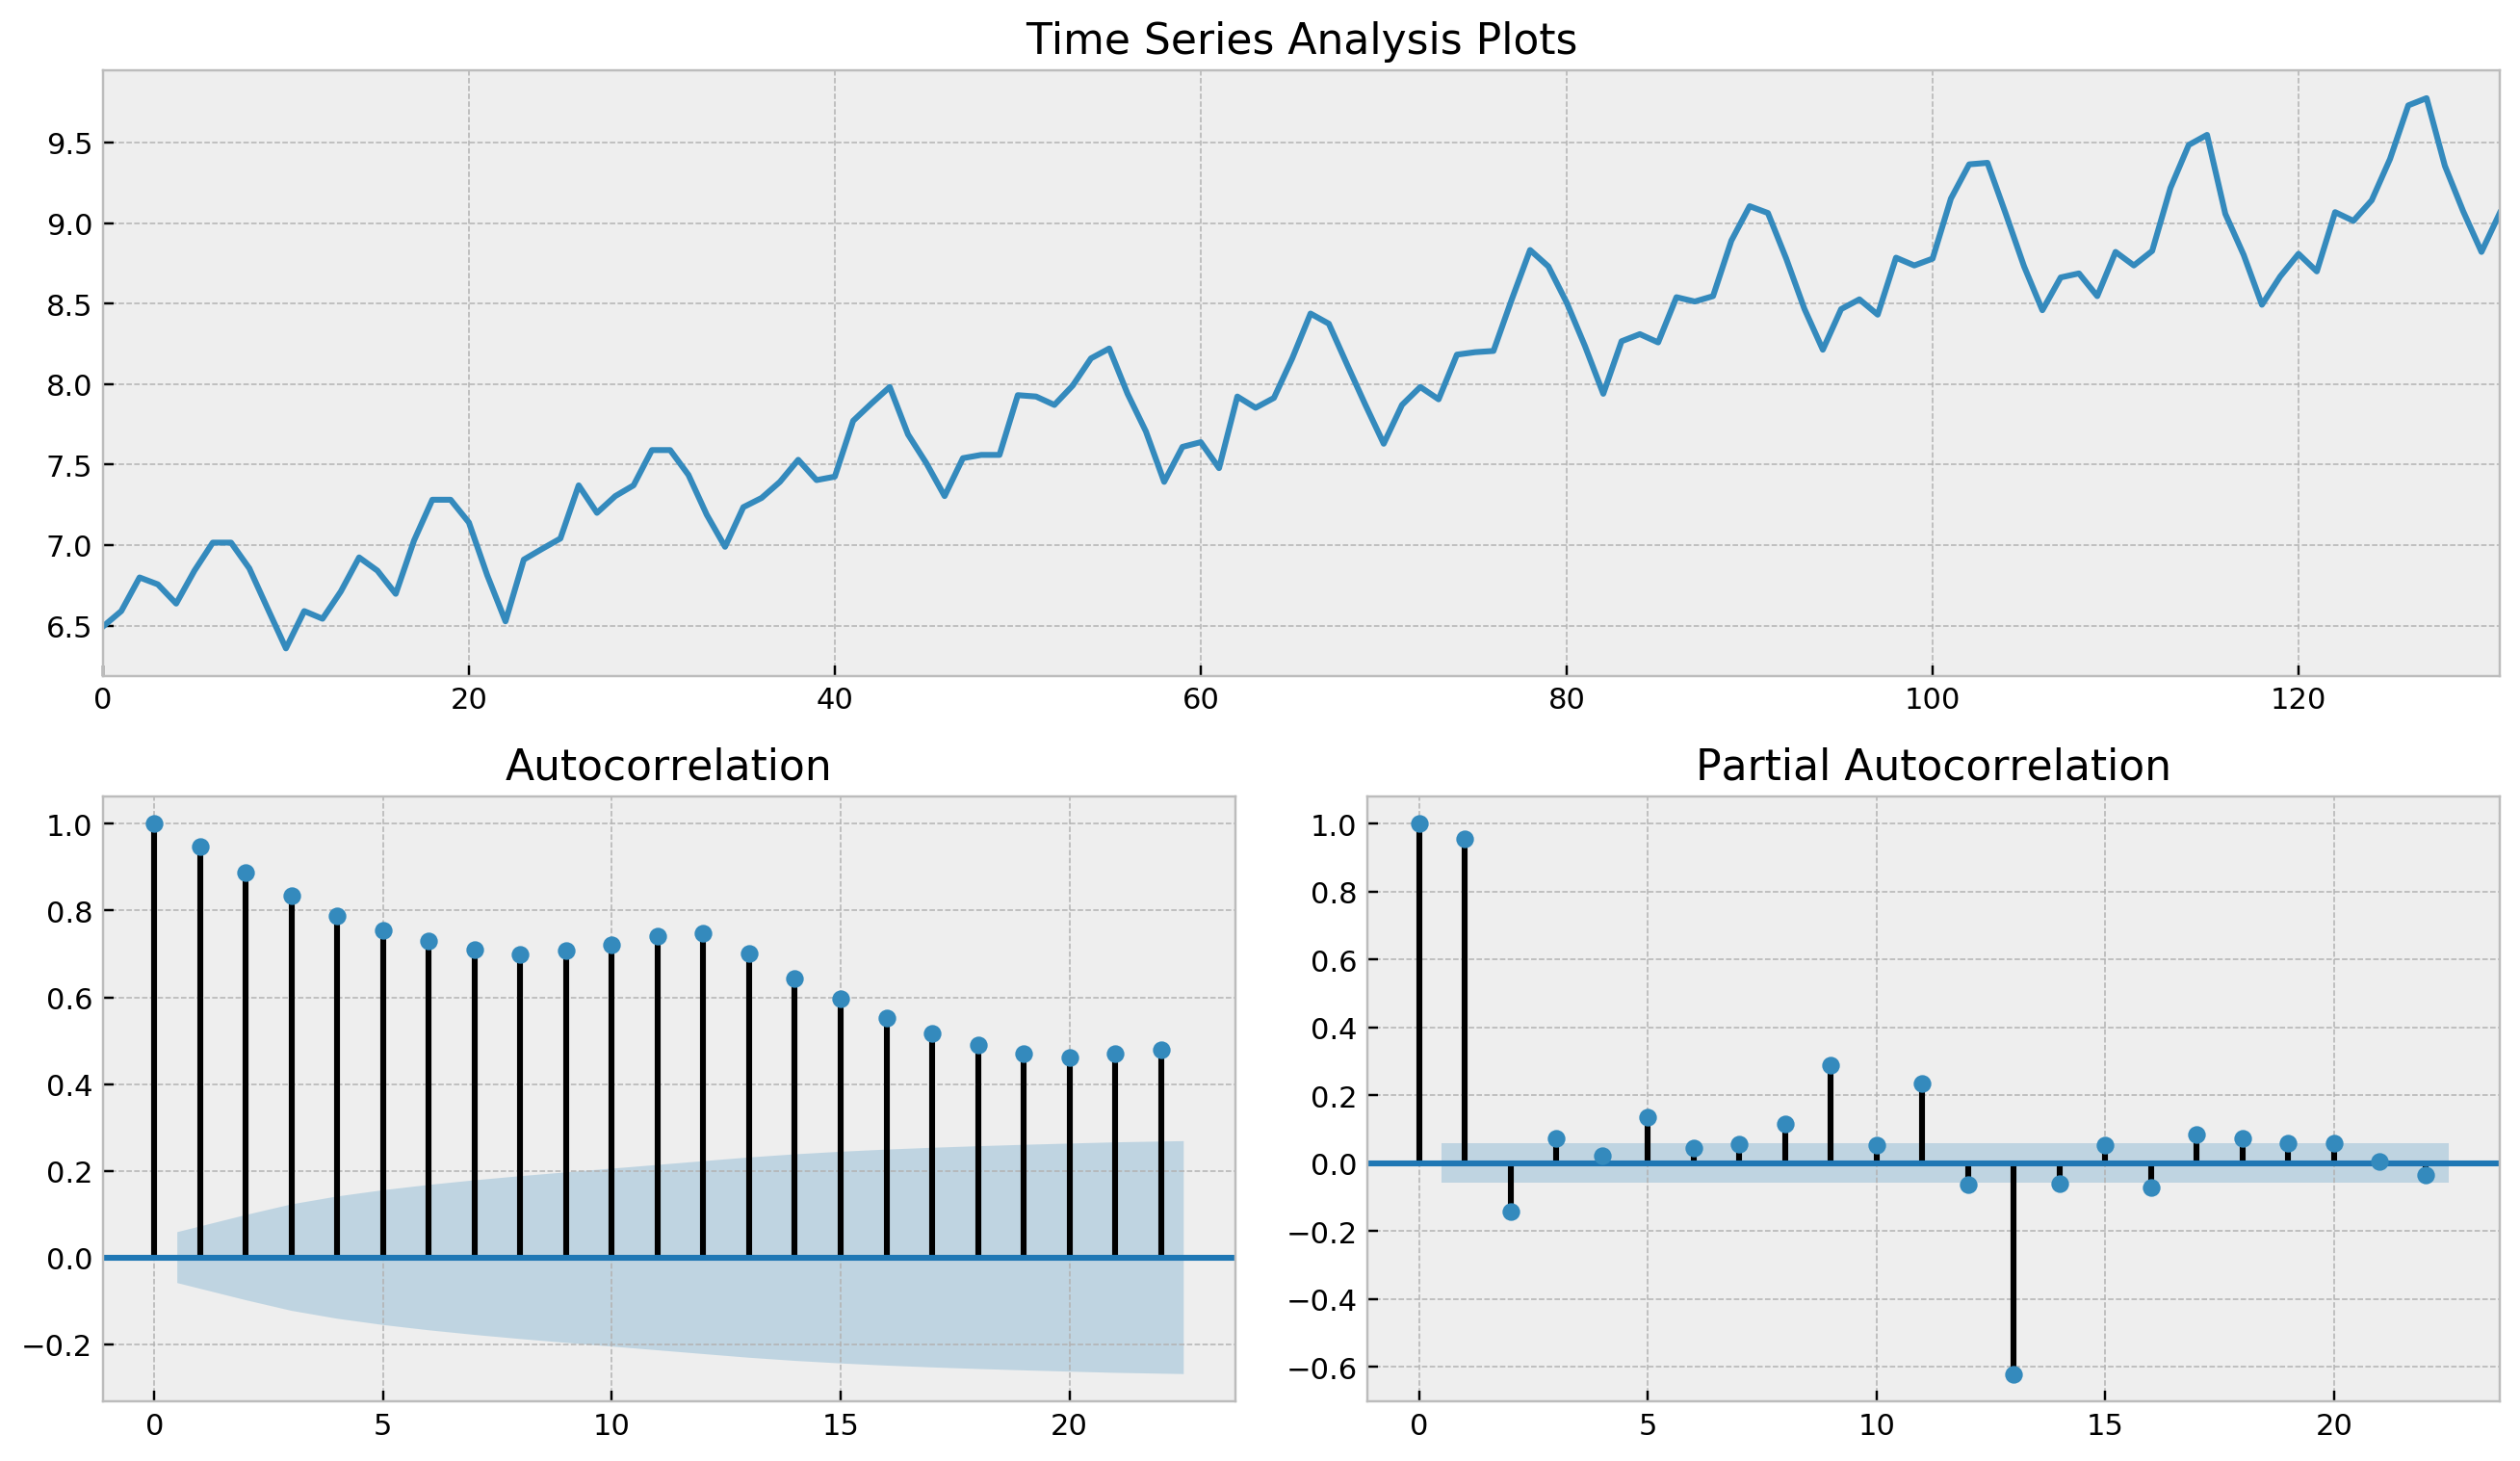

In [7]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

data = train_df.copy()
data['Passengers_box'], lmbda = scs.boxcox(train_df["#Passengers"])
tsplot(data['Passengers_box'])
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)

Критерий Дики-Фуллера: p=0.082593


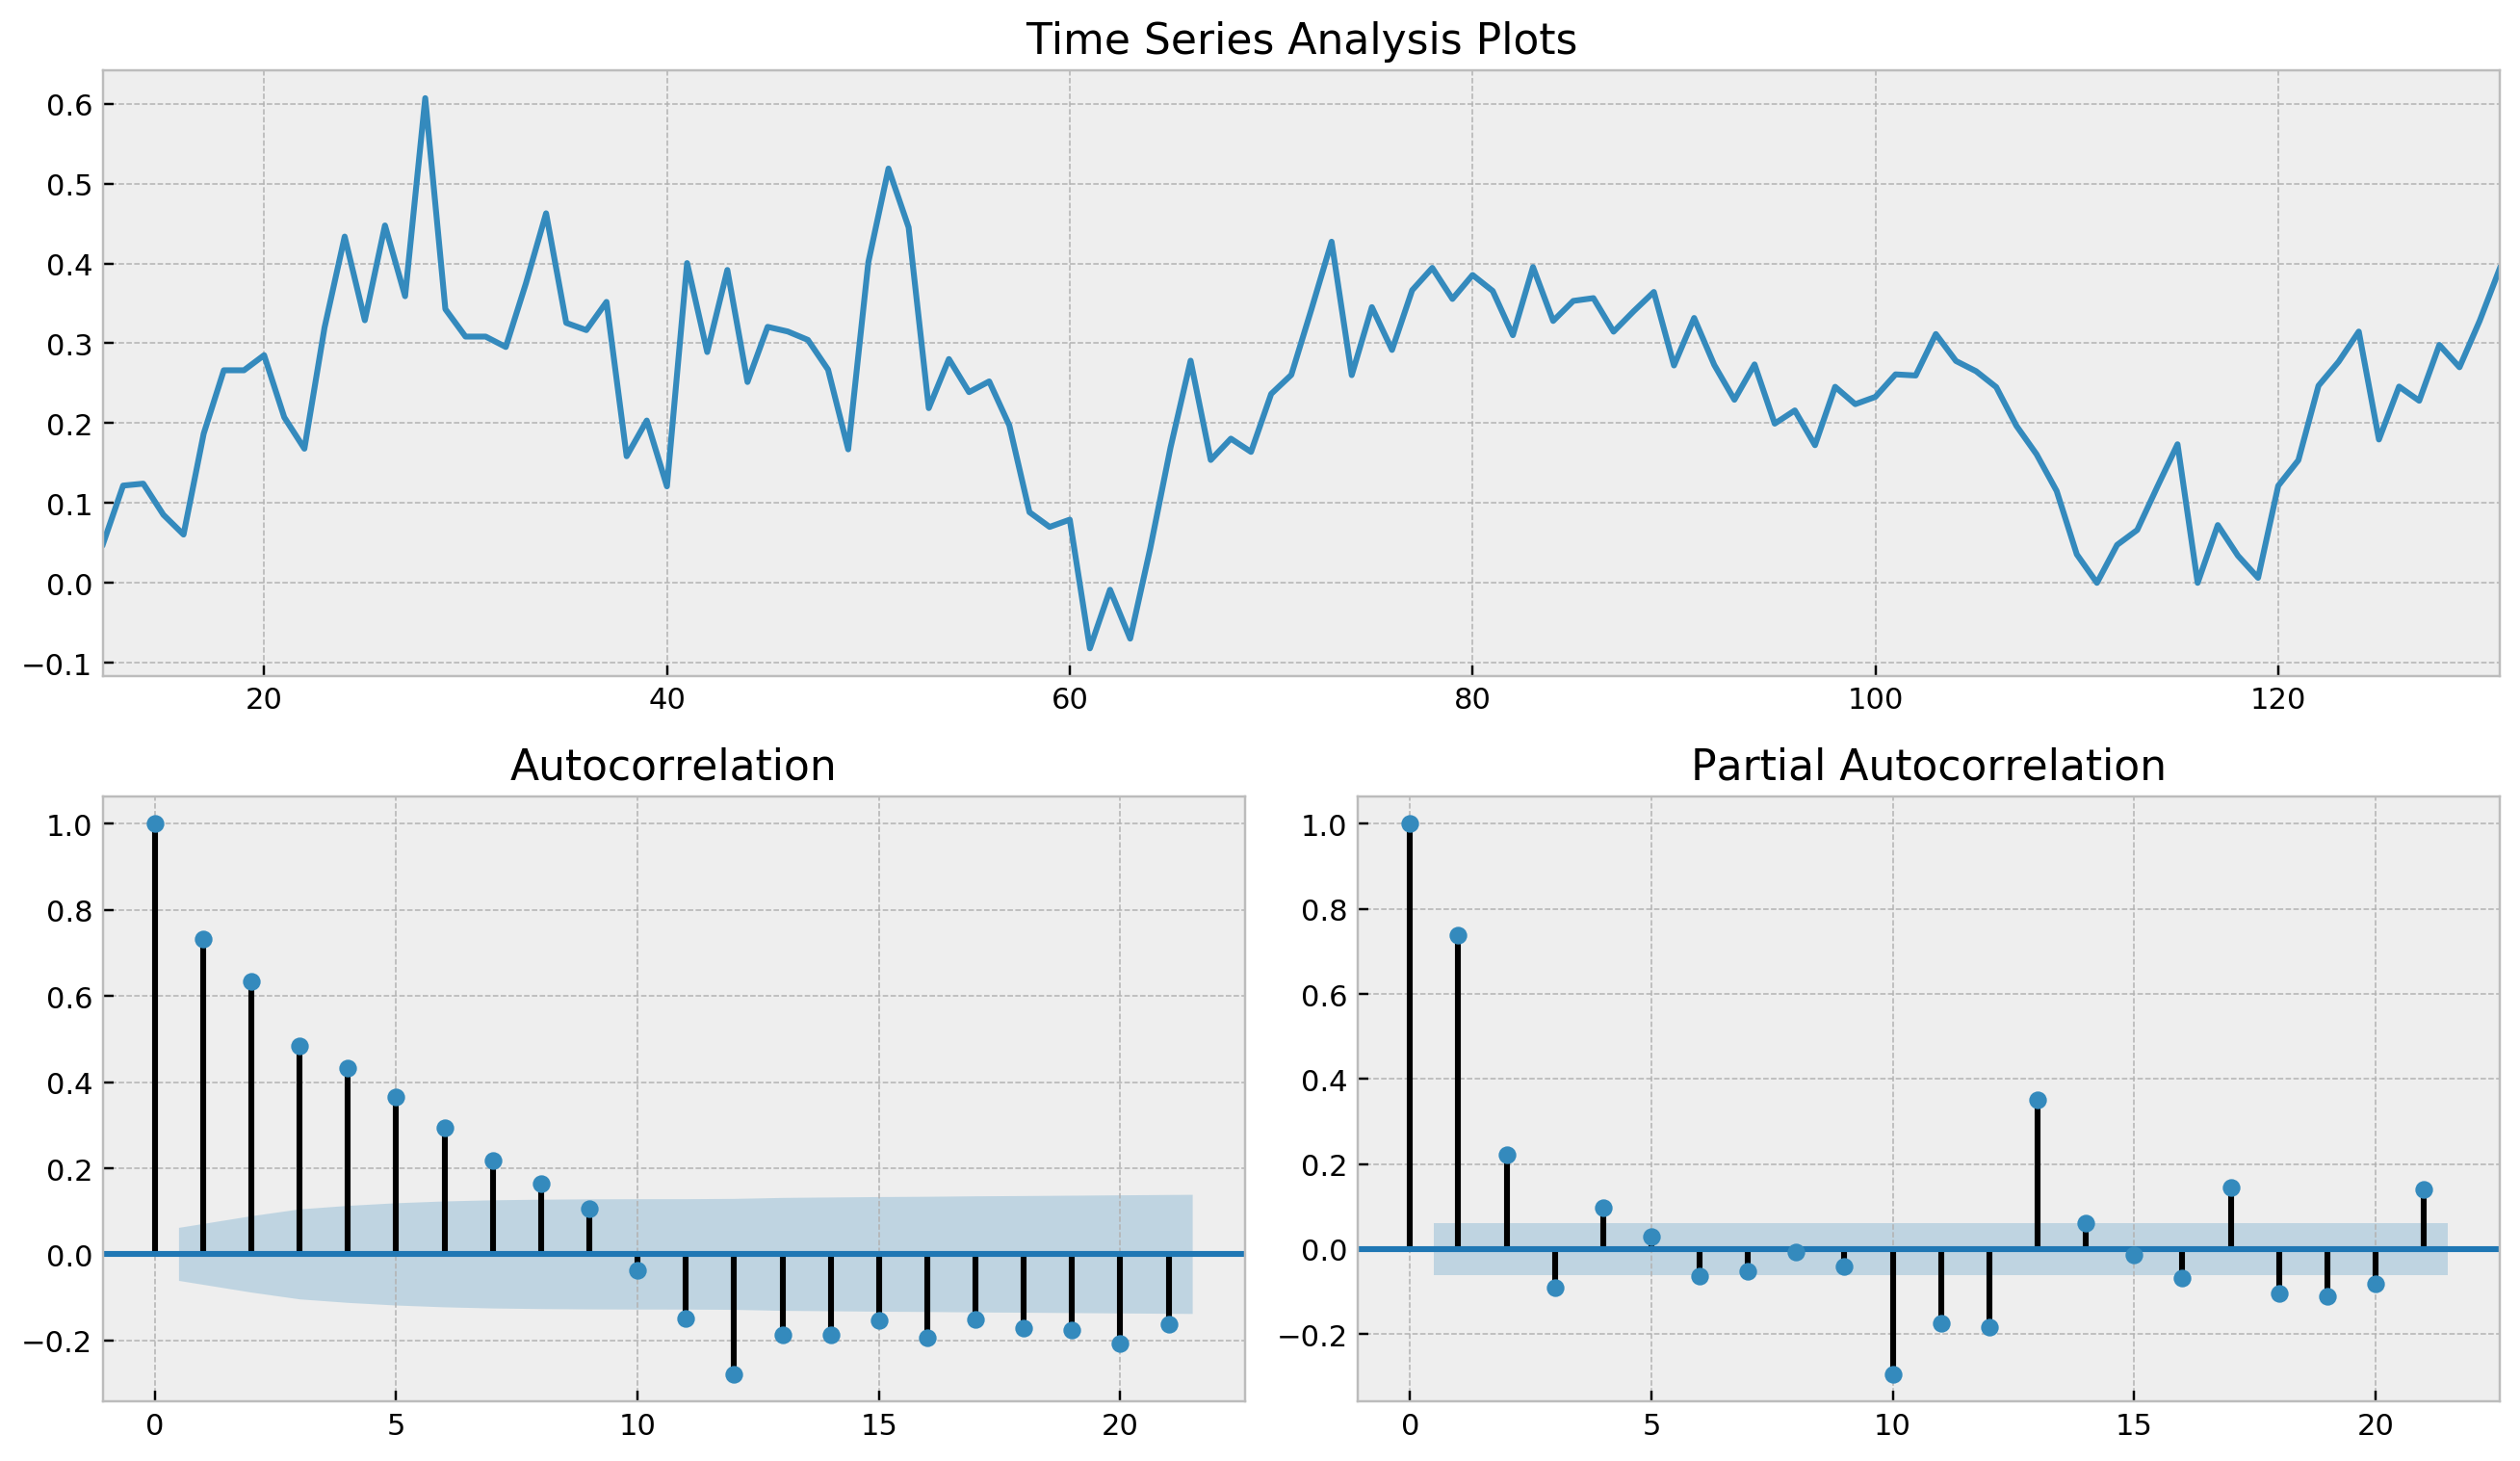

In [8]:
data['Passengers_box_season'] = data['Passengers_box'] - data['Passengers_box'].shift(season_len)
tsplot(data['Passengers_box_season'][season_len:])

Критерий Дики-Фуллера: p=0.001172


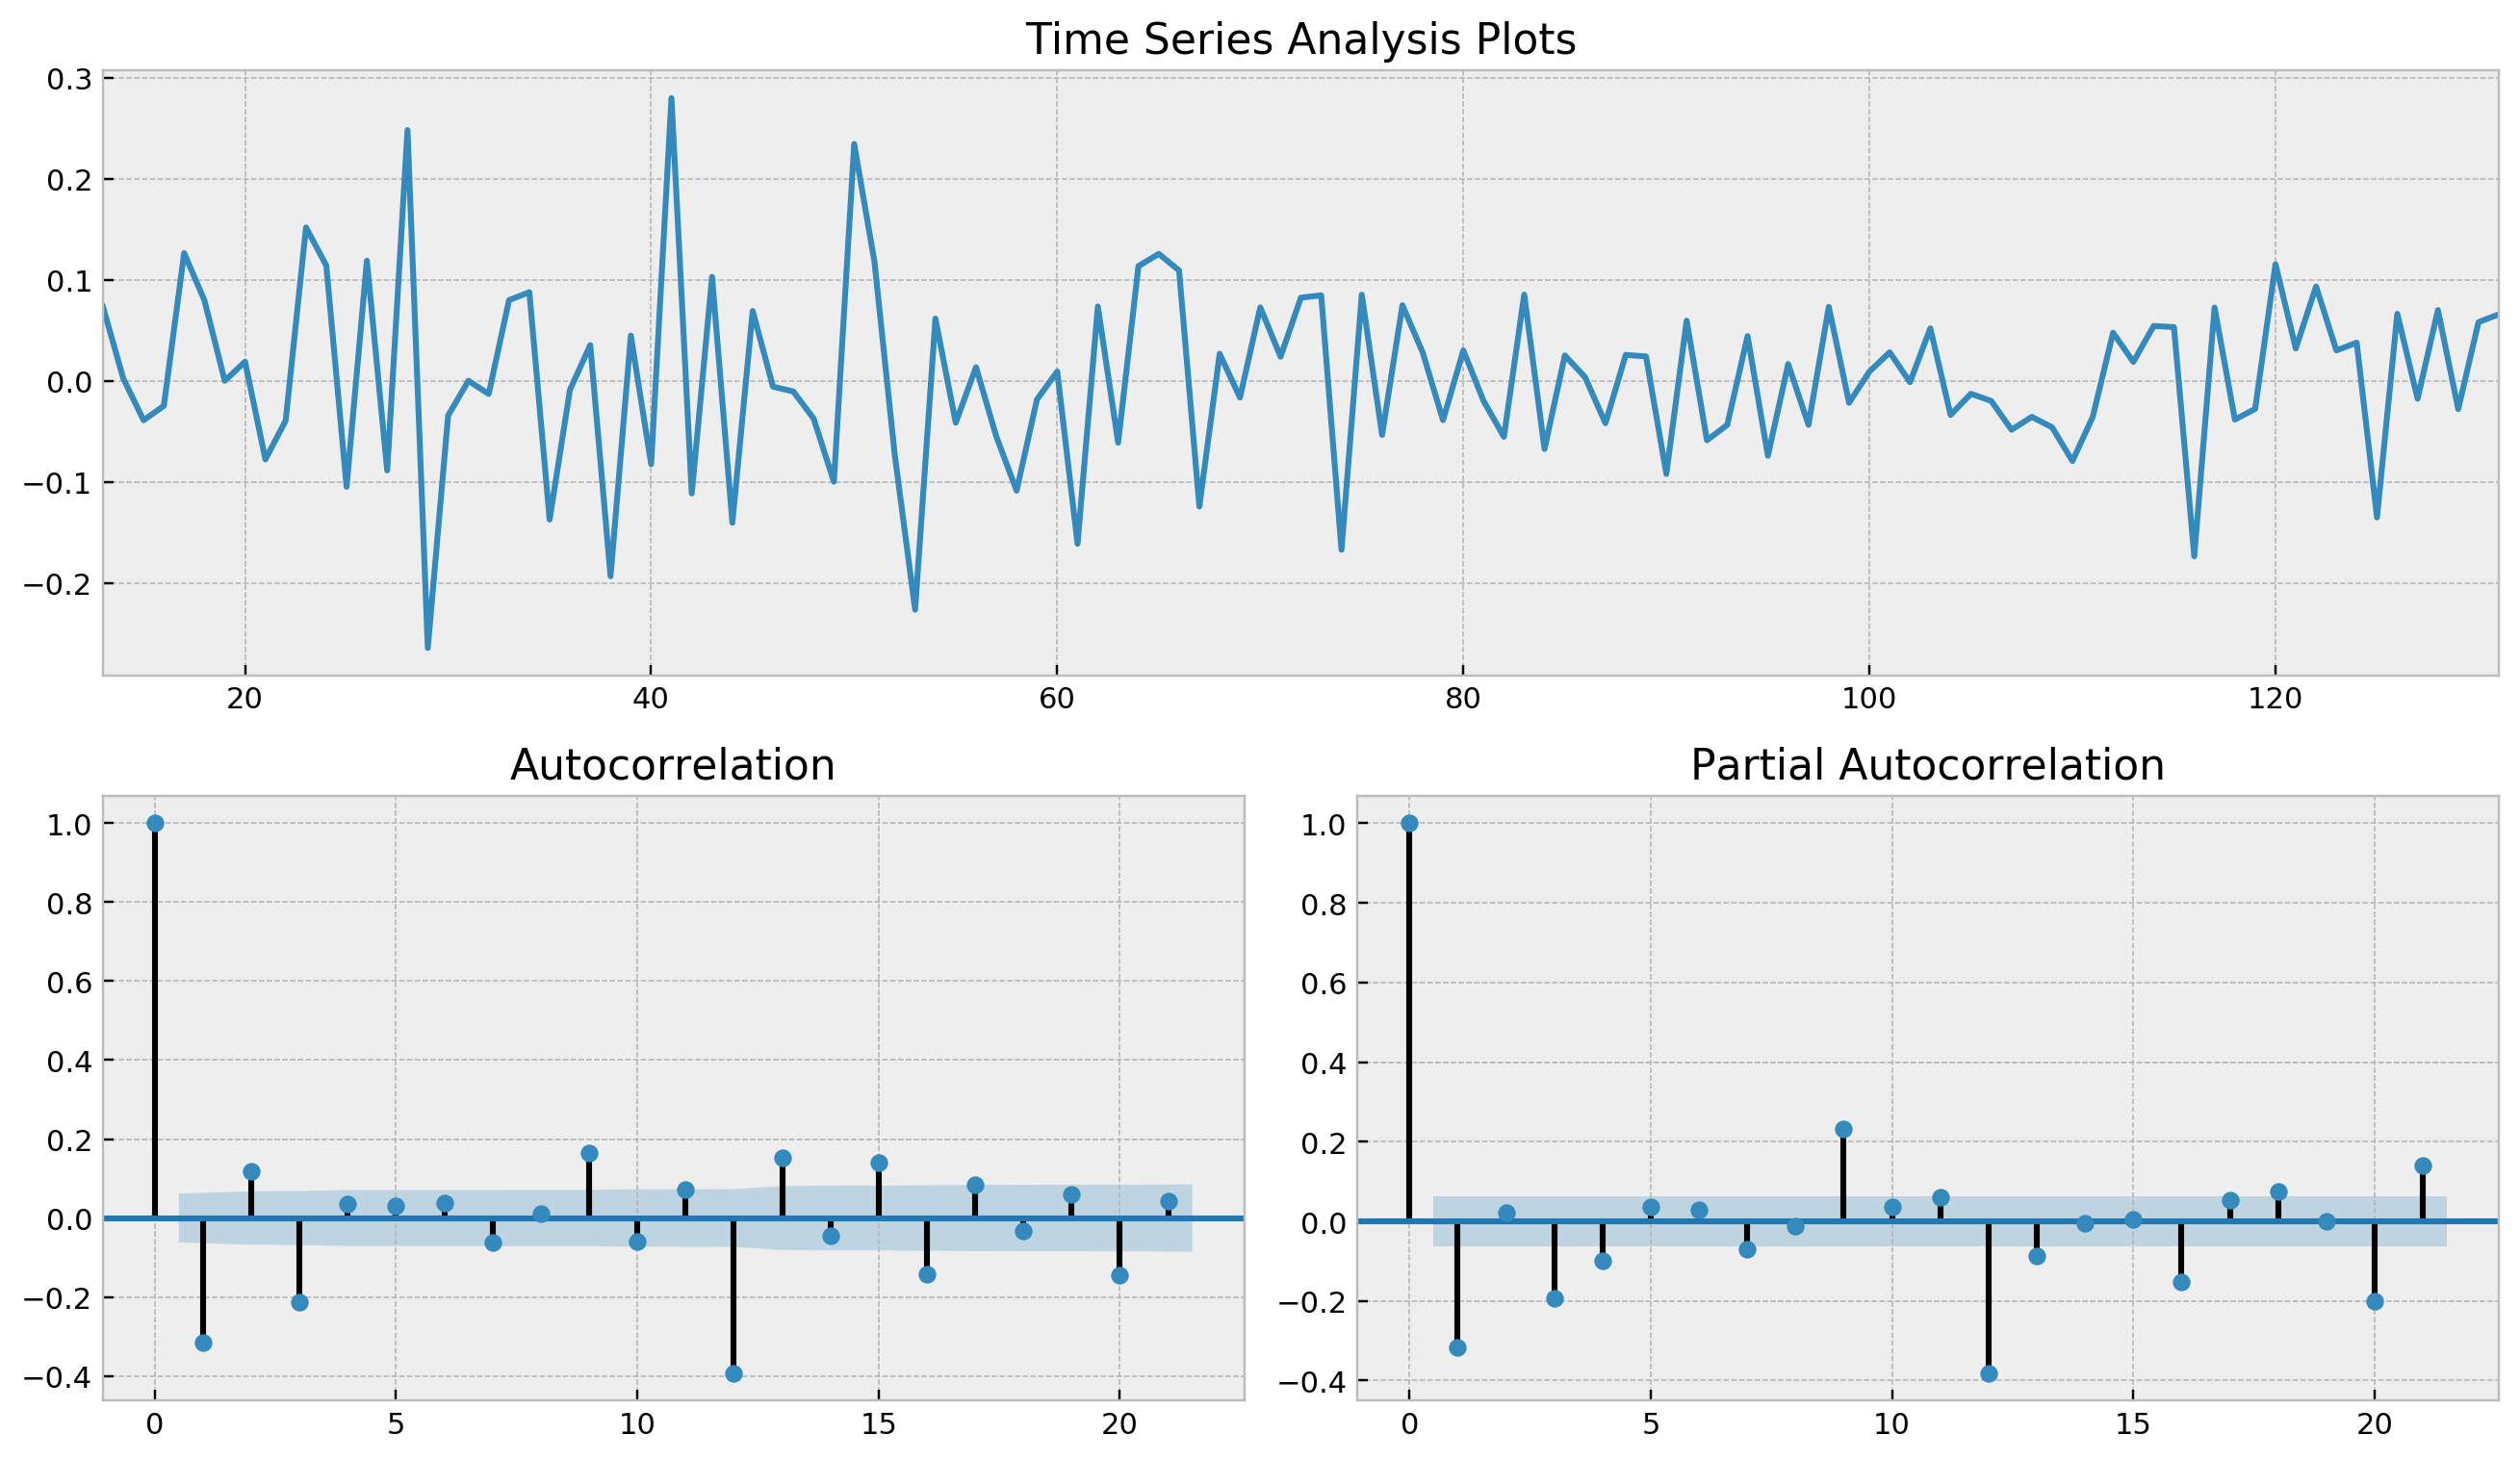

In [9]:
data['Passengers_box_season_diff'] = data['Passengers_box_season'] - data['Passengers_box_season'].shift(1)
tsplot(data['Passengers_box_season_diff'][season_len+1:])

In [11]:
ps = range(0, 3)
d=1
qs = range(0, 3)
Ps = range(0, 3)
D=1
Qs = range(0, 1)

parameters = itertools.product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

27

In [12]:
%%time
results = []
best_aic = float("inf")

from tqdm import tqdm
warnings.filterwarnings("ignore")

for param in tqdm(parameters_list):
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data['Passengers_box'], order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], season_len)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
result_table.sort_values(by = 'aic', ascending=True).head()

100%|██████████| 27/27 [00:15<00:00,  1.70it/s]

CPU times: user 21.1 s, sys: 10.1 s, total: 31.3 s
Wall time: 15.9 s


,parameters,aic
23,"(2, 1, 2, 0)",-270.397938
5,"(0, 1, 2, 0)",-270.289282
11,"(1, 0, 2, 0)",-270.061695
4,"(0, 1, 1, 0)",-268.890389
22,"(2, 1, 1, 0)",-268.885934


In [13]:
best_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                     Passengers_box   No. Observations:                  132
Model:             SARIMAX(2, 1, 1)x(2, 1, 0, 12)   Log Likelihood                 141.199
Date:                            Wed, 22 Apr 2020   AIC                           -270.398
Time:                                    16:58:47   BIC                           -253.723
Sample:                                         0   HQIC                          -263.627
                                            - 132                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5993      0.101      5.936      0.000       0.401       0.797
ar.L2          0.2489      0.096      2.593      0.010       0.061       0.437
ma.L1         -0.9849      0.097    -10.150      0.000      -1.175      -0.795
ar.S.L12      -0.5169      0.106     -4.881      0.000      -0.725      -0.309
ar.S.L24      -0.2024      0.117     -1.727      0.084      -0.432       0.027
sigma2         0.0053      0.001      6.877      0.000       0.004       0.007
===================================================================================
Ljung-Box (Q):                       35.12   Jarque-Bera (JB):                 2.20
Prob(Q):                              0.69   Prob(JB):                         0.33
Heteroskedasticity (H):               0.47   Skew:                             0.04
Prob(H) (two-sided):                  0.02   Kurtosis:                         3.66
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Критерий Дики-Фуллера: p=0.000000


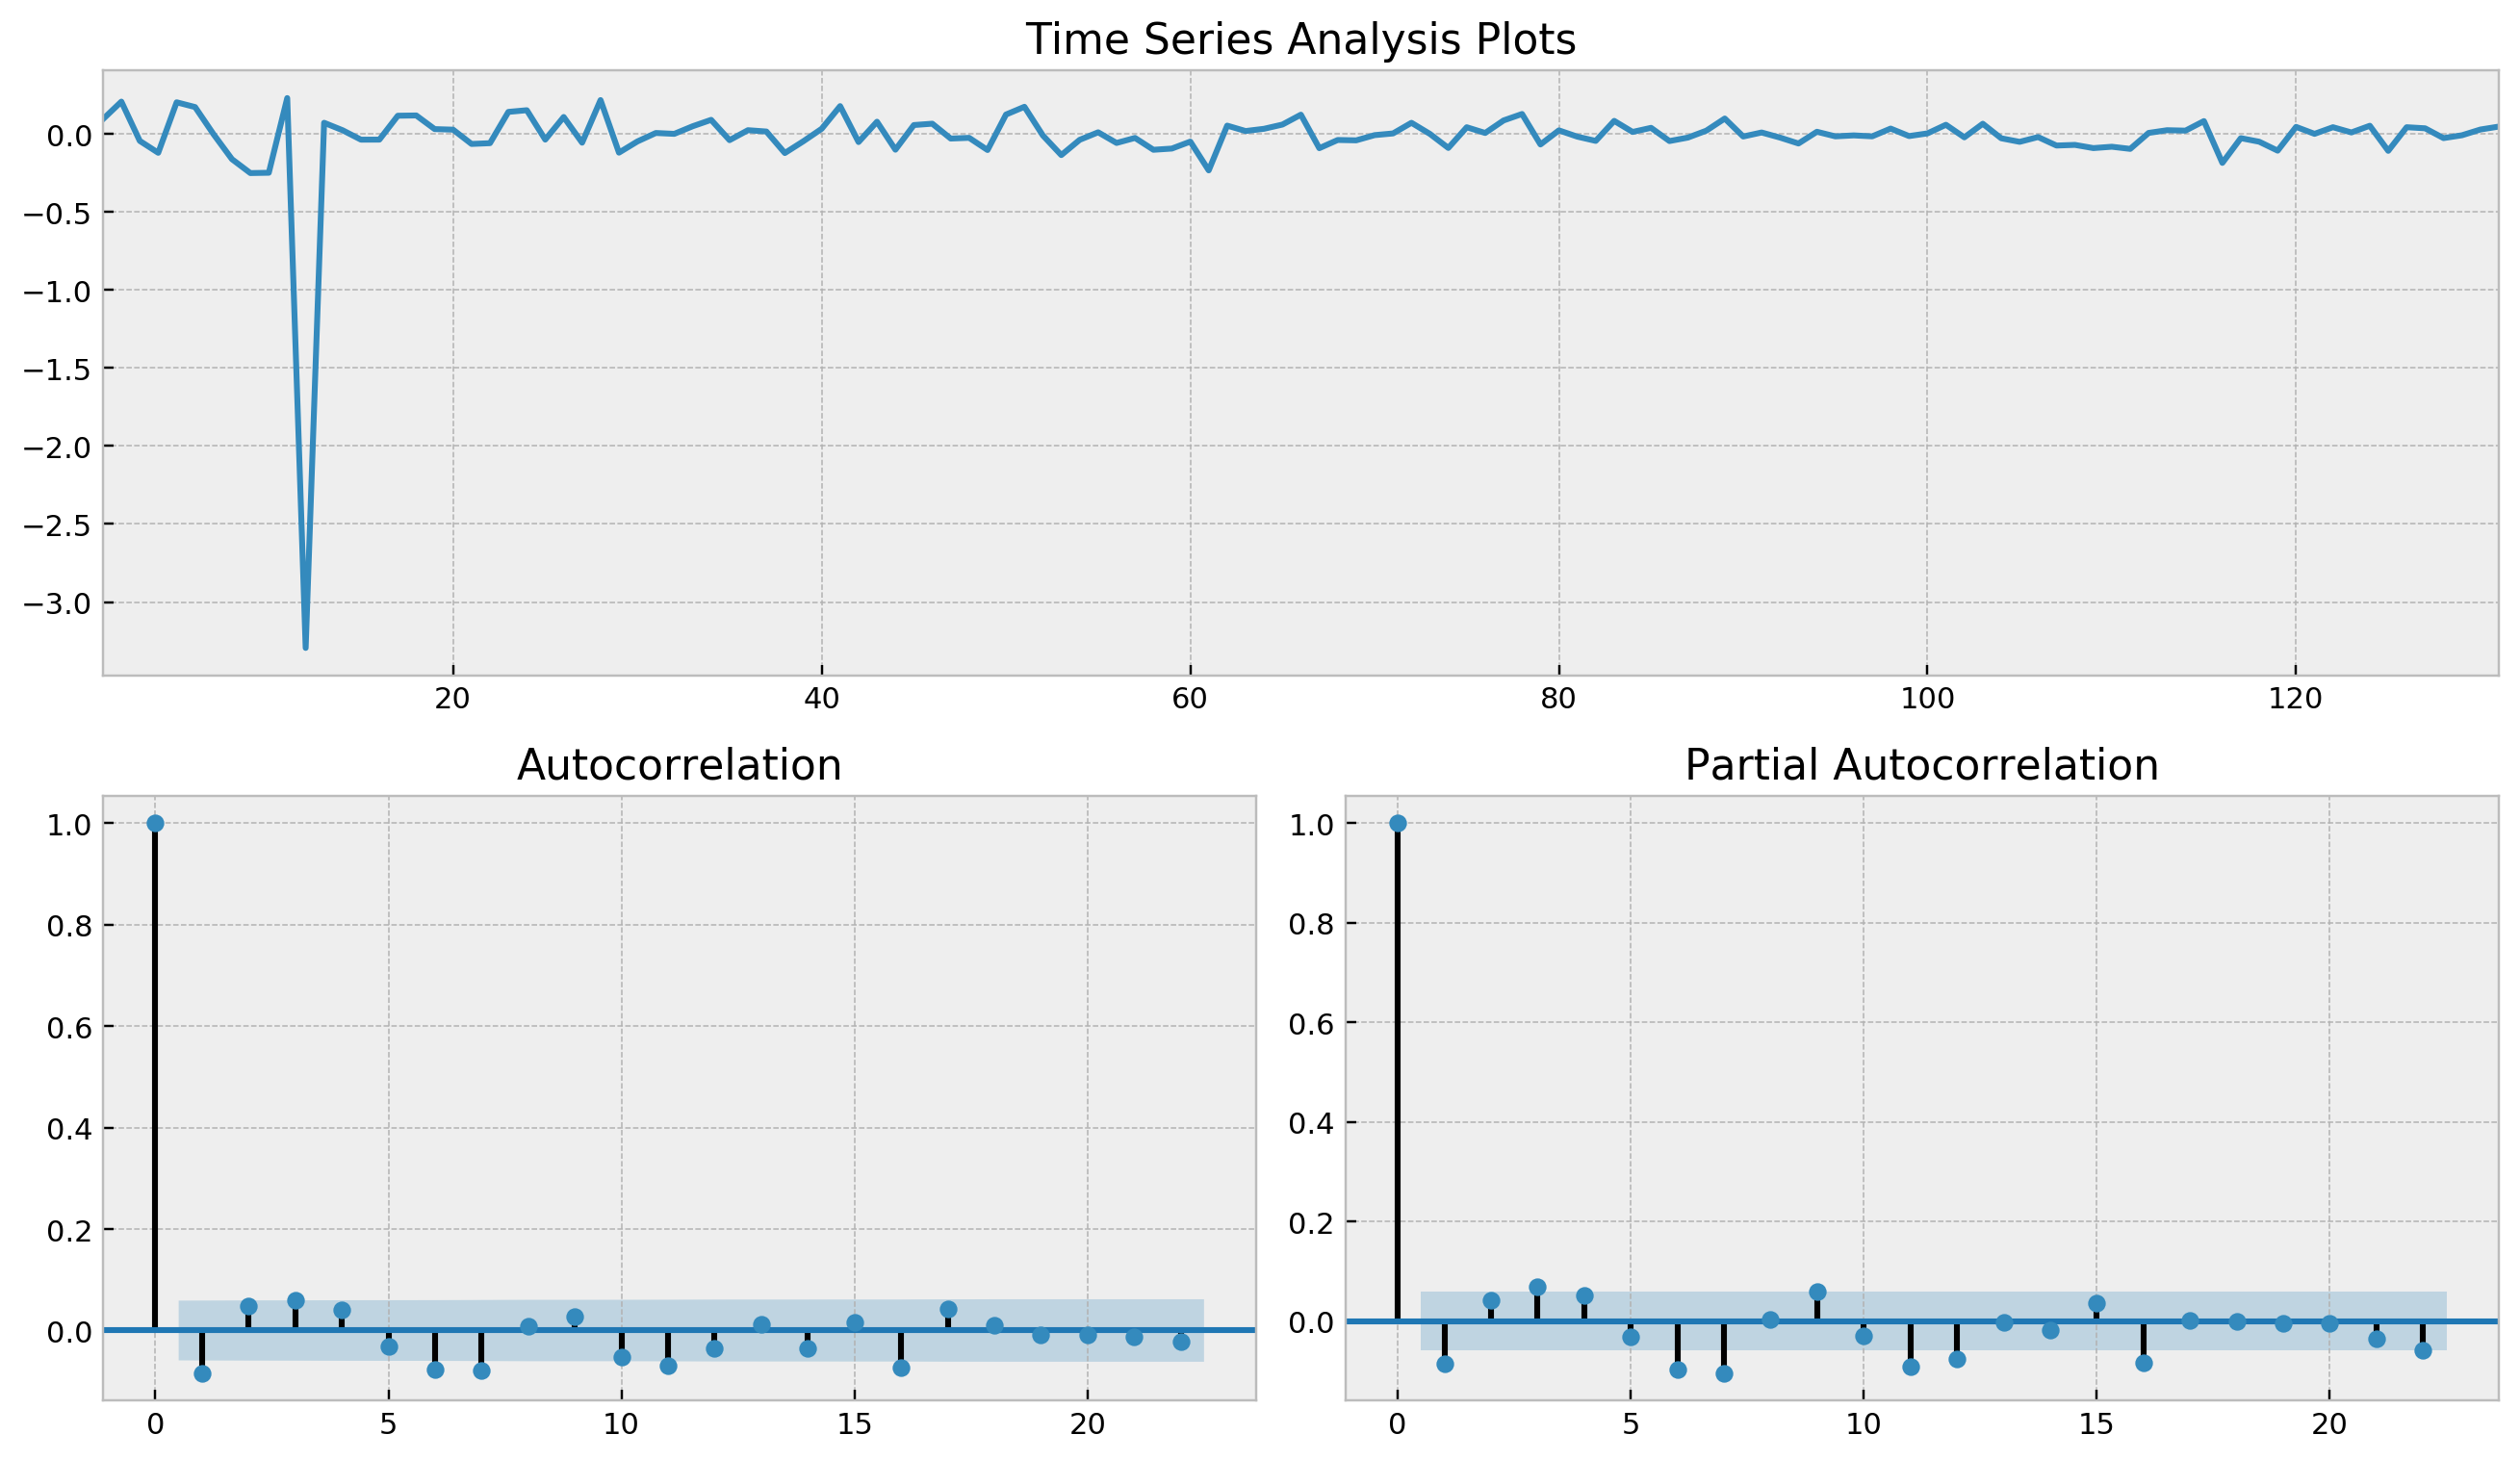

In [14]:
tsplot(best_model.resid[1:])

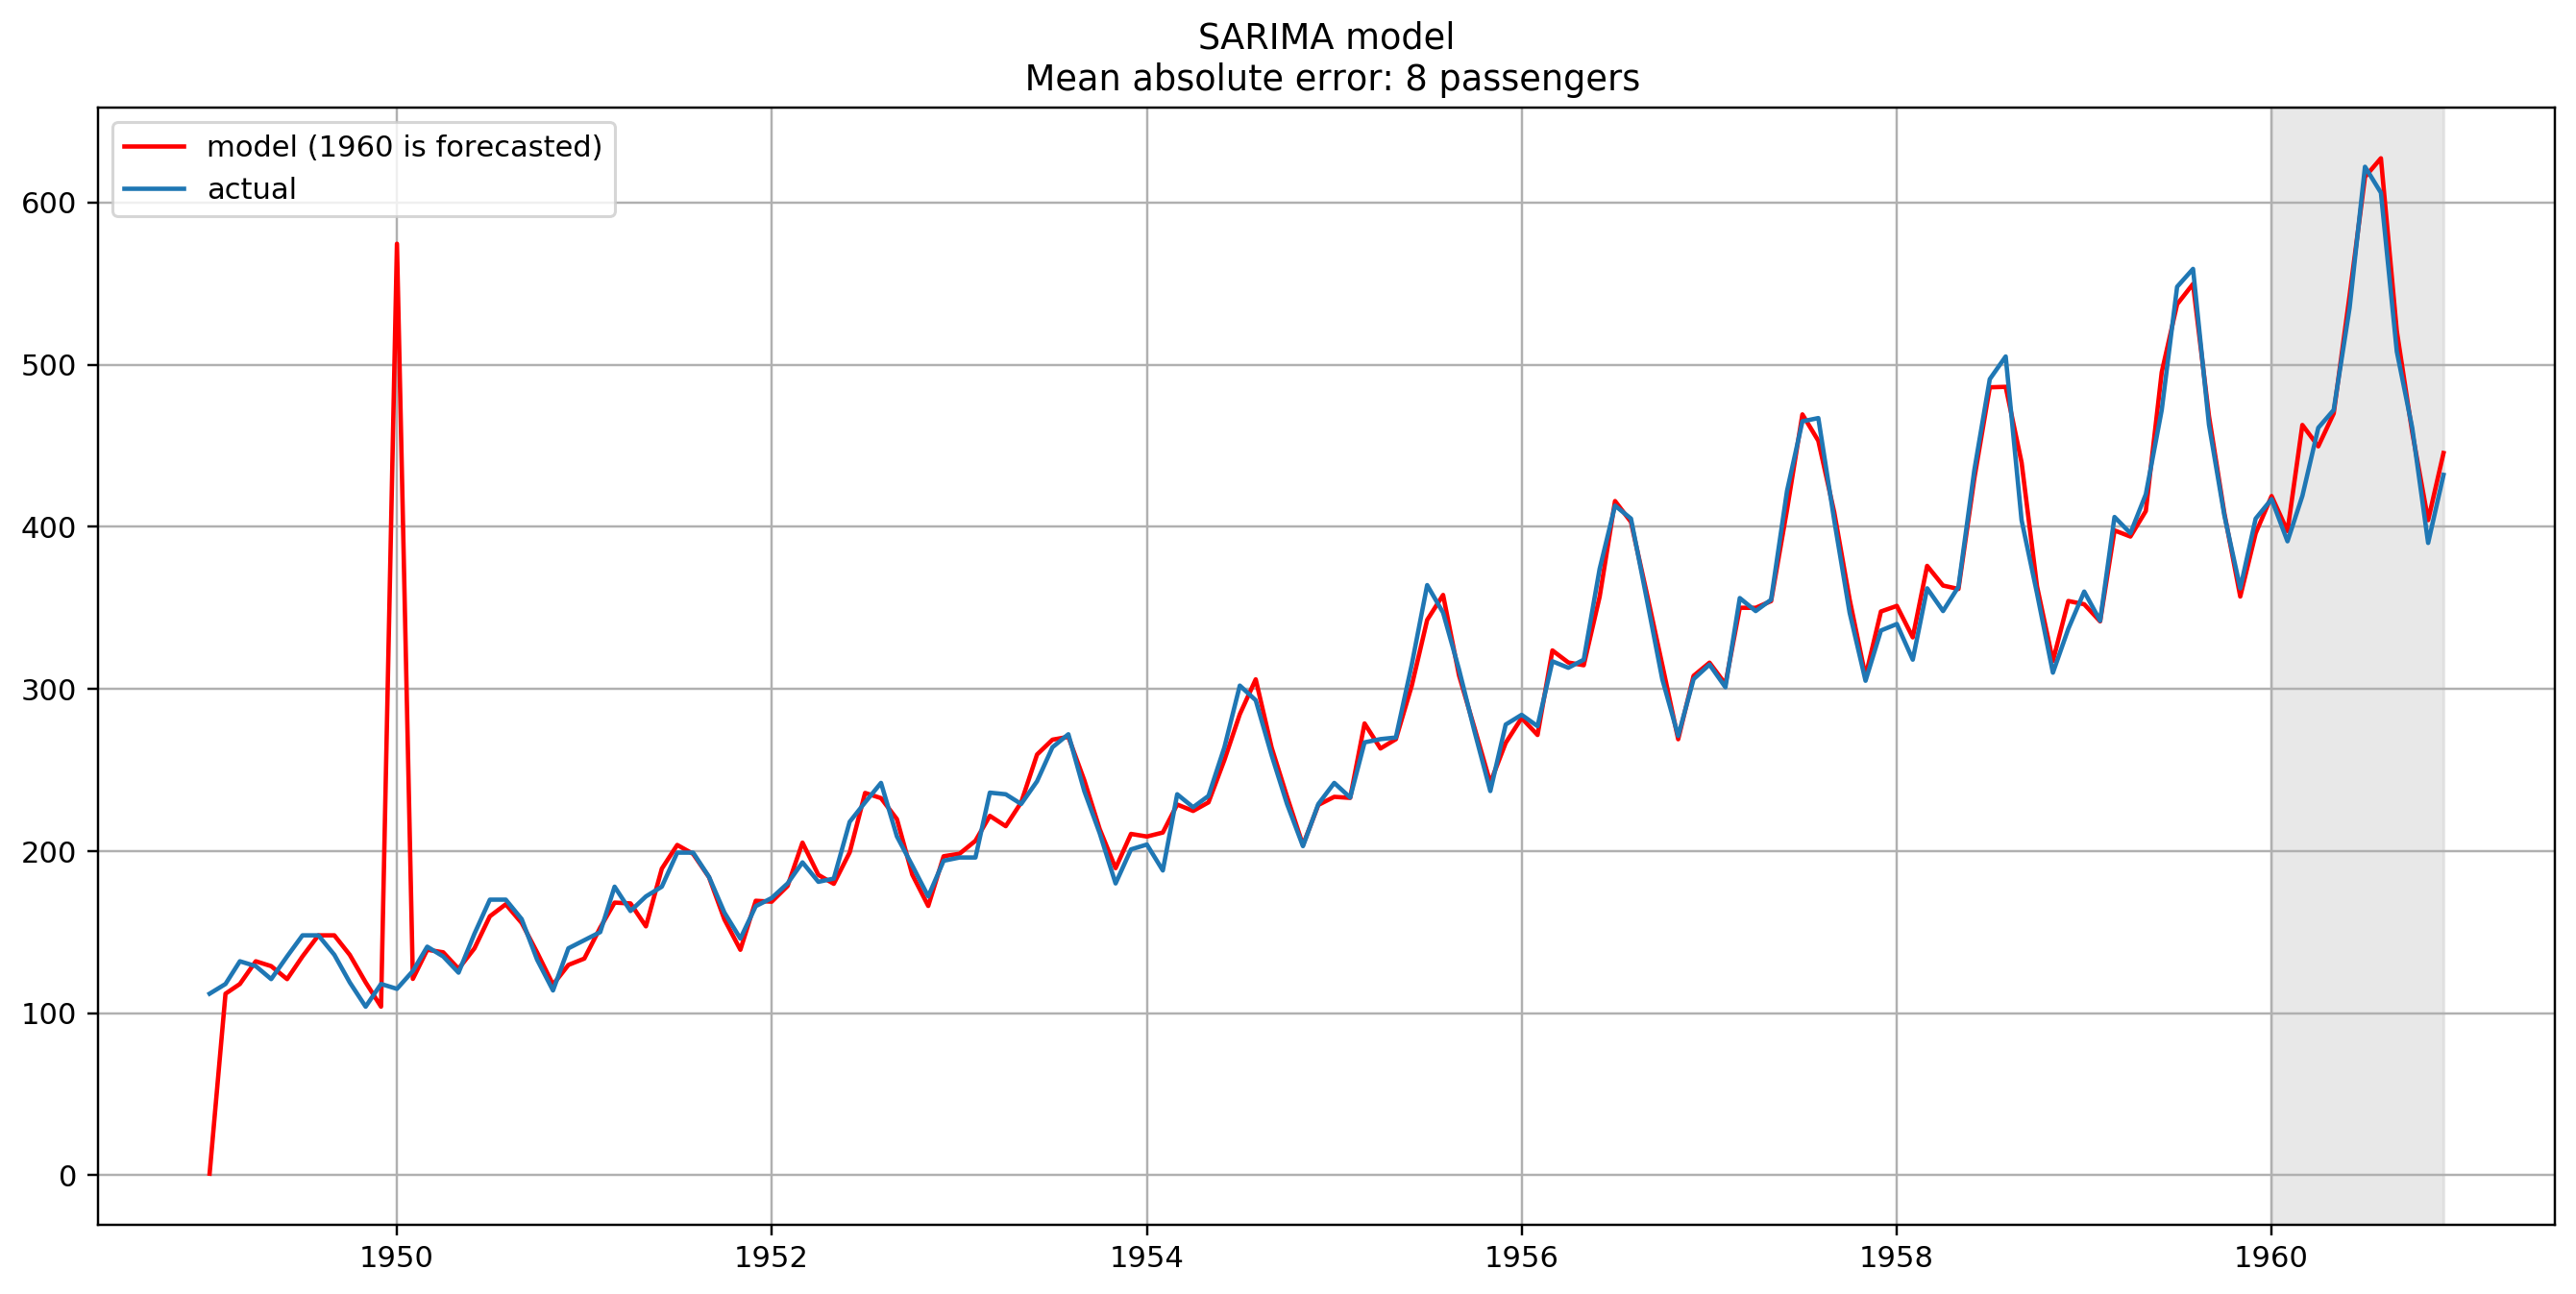

In [15]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

data['arima_model'] = invboxcox(best_model.fittedvalues, lmbda)
forecast = invboxcox(best_model.predict(start = data.shape[0], end = data.shape[0]+points_to_drop-1), lmbda)
forecast = data['arima_model'].append(forecast).values[:]
actual = df['#Passengers'].values[:]
plt.figure(figsize=(15, 7), dpi=220)
plt.plot(df['dt'].values[:], forecast, color='r', label="model (1960 is forecasted)")
ma_error = int(round(
    mean_absolute_error(
        data['#Passengers'].iloc[-points_to_drop:], 
        data['arima_model'].iloc[-points_to_drop:]
    )
))
plt.title(f"SARIMA model\n Mean absolute error: {ma_error} passengers")
plt.plot(df['dt'].values[:], actual, label="actual")
plt.legend()
plt.axvspan(df['dt'].iloc[-points_to_drop], df['dt'].iloc[-1], alpha=0.5, color='lightgrey')
plt.grid(True)